# Expert versus Crowdworkers
This notebook explores the impact of high-quality, expert captions on reference-based metrics when evaluating VLM captions.

In [8]:
import json
import copy

import pandas as pd

import statistics as s
from bert_score import score
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


# Load Data
You need two files to use this notebook:
1. A file with captions from crowdworkers and model captions. Keys must include `file_name`, `human_captions`, `model_captiosn`.
2. A file with captions from experts. Keys must include `file_name`, and `expert_caption`.

`file_name` is used to match the files together.

In [9]:
# load caption file with evaluations
crowdworker_data = None
filepath = "../data/study-2-output/labeled-data/evaluation-results/evaluation_results_5432-images_2025-04-03_11:27_fixed.json"
with open(
    filepath,
    "r",
) as f:
    crowdworker_data = json.load(f)
crowdworker_data[0:1]

[{'image_id': 1,
  'file_name': 'VizWiz_train_00000001.jpg',
  'vizwiz_url': 'https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00000001.jpg',
  'text_detected': True,
  'unrecognizable': 0,
  'framing': 0,
  'blur': 5,
  'obstruction': 0,
  'rotation': 0,
  'too dark': 0,
  'too bright': 0,
  'other': 0,
  'no issue': 0,
  'human_captions': [{'caption': 'A can of Coca Cola on a counter is shown for when one can use a nice, cold drink.',
    'is_precanned': False,
    'is_rejected': False},
   {'caption': 'A black can of Coca Cola Zero calorie soda is on the counter near the coffee maker.',
    'is_precanned': False,
    'is_rejected': False},
   {'caption': 'A kitchen counter the various items on top including a can of Coca-Cola, metal containers, and a teapot.',
    'is_precanned': False,
    'is_rejected': False},
   {'caption': 'a black tin of Coca Cola placed on a black surface',
    'is_precanned': False,
    'is_rejected': False},
   {'caption': 'Black counter

In [12]:
# load expert caption data
expert_caption_data_df = pd.read_csv("../data/vqa/image-quality-vqa-dataset.csv")
expert_caption_data_df

,image_name,vizwiz_url,question,question_type,expert_answer,text_detected,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright,human_caption_1,human_caption_2,human_caption_3,human_caption_4,human_caption_5
0,VizWiz_train_00012786.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What kind of chips are these?,Identification,"These are hot crunchy cheese curls in yellow, ...",True,0,4,0,0,1,0,0,imagine how you would describe this image on t...,"A red, yellow and black upside down bag of Hot...",An upside down bag of cheese puffs on a light ...,"A bag of crunchy curls that says ""hot"" on it.",a bag of oven baked hot crunchy cheese curls
1,VizWiz_train_00001603.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is it?,Identification,The photo shows a partial view of a white and ...,True,0,0,5,0,4,0,0,A white and orange package of skinny cow brand...,A white and orange box of crisp chocolate bar ...,A photo of skinny cow heavenly crisps candy b...,image shows a door of a restaurant with adds.,A white door with a silver knob next to a crea...
2,VizWiz_train_00010594.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is this please?,Identification,I'm pretty sure that is a can of chicken noodl...,True,1,5,1,0,3,1,0,Quality issues are too severe to recognize vis...,Here is a picture of a can of chicken noodle soup,An upside down white metal can of soup.,Pictured is a can of chicken noodle soup.,A person is holding a can of soup.
3,VizWiz_train_00015006.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,what is inside this can?,Identification,This seems to be some sort of creamy potato so...,True,0,3,4,0,5,0,0,a can of potato cream soup on a counter with a...,A can of Campbell's cream of potato soup.,A can of Campbell's Cream of Potato soup,"A can of Campbell's soup, flavored cream of po...",An upside down cylindrical tin can of soup sho...
4,VizWiz_train_00002353.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is in this bottle?,Identification,I can't tell what is in the bottle. \nIf I had...,True,0,4,5,0,0,0,0,a hand holding a jar of maybe vinegar for vegg...,A bottle of something that appears to be vineg...,A bottle of apple cider vinegar with a red label,"A hand holding up a full bottle of liquid, wit...",Part of a bottle of salad dressing with an ora...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,VizWiz_train_00013989.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What kind of price of dinner is this?,Others,This frozen dinner is usually around $5. This ...,True,0,1,4,0,0,1,0,one pack of meat loaf and gravy mix,a green box of microwavable dinner with meat l...,Meatloaf and gravy packaging with Two Slices o...,A package of meat loaf and gravy (two slices o...,"A green plastic package with the words ""MeatLo..."
96,VizWiz_train_00015759.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What side will turn off the oven? Is it the l...,Others,This image is too blurry to see an oven.,True,2,3,1,5,0,2,1,Quality issues are too severe to recognize vis...,A computer screen has a start button and a clo...,A touchpad on a microwave has all of the setti...,Quality issues are too severe to recognize vis...,A control panel for an electronic appliance wi...
97,VizWiz_train_00011055.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What's the general theme of these books? Thanks.,Others,These ten books are all about French history. ...,True,1,0,4,0,3,0,0,a lot of multi color books were put together i...,multiple library books on two metal shelving u...,Quality issues are too severe to recognize vis...,The section of library books on the lower shel...,A bookcase sitting on a silver shelf among oth...
98,VizWiz_train_00015986.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,"Good morning, could you please tell me what is...",Others,The image is to out of focus for me to read th...,True,1,5,2,0,0,0,0,Quality issues are too severe to recognize v

## Merge Datasets

In [28]:
relevant_images = set(expert_caption_data_df["image_name"])
crowdworker_data_for_df = []
for image in crowdworker_data:
    curr_output = {}
    if image["file_name"] in relevant_images:
        curr_output["file_name"] = image["file_name"]
        # curr_output["unrecognizable"] = image["unrecognizable"]
        # curr_output["framing"] = image["framing"]
        # curr_output["blur"] = image["blur"]
        # curr_output["obstruction"] = image["obstruction"]
        # curr_output["rotation"] = image["rotation"]
        # curr_output["too dark"] = image["too dark"]
        # curr_output["too bright"] = image["too bright"]

        for caption in image["model_captions"]:
            curr_output[caption["model_name"]] = caption["caption"]
        crowdworker_data_for_df.append(curr_output)
crowdworker_data_for_df[0:1]

crowdworker_data_df = pd.DataFrame(crowdworker_data_for_df)
crowdworker_data_df.head()

,file_name,gpt-4o-2024-08-06,Llama-3.2-11B-Vision-Instruct,Molmo-7B-O-0924
0,VizWiz_train_00000065.jpg,A section of packaging instructions is visible...,"The image shows a white, rectangular package w...",The image shows a plastic container with a gre...
1,VizWiz_train_00000700.jpg,A spice jar with a visible barcode and orange ...,"The image shows a glass jar with a brown lid, ...",A spice jar with a white label and barcode is ...
2,VizWiz_train_00000791.jpg,A partially visible dollar bill is placed on a...,The image shows a green bill with a green bord...,A $100 bill is visible on a dark brown leather...
3,VizWiz_train_00001015.jpg,"A hand holds a red box with the text ""Betty Cr...",The image shows a hand holding a red box with ...,The image shows a Betty Crocker box of cake mi...
4,VizWiz_train_00001353.jpg,A person is holding a bottle of Samuel Adams N...,The image shows a brown glass bottle with a bl...,The image shows a bottle of Samuel Adams beer ...


In [31]:
merged_df = pd.merge(
    expert_caption_data_df,
    crowdworker_data_df,
    left_on="image_name",
    right_on="file_name",
)
del merged_df["file_name"]
merged_df.head()

,image_name,vizwiz_url,question,question_type,expert_answer,text_detected,unrecognizable,blur,framing,obstruction,...,too dark,too bright,human_caption_1,human_caption_2,human_caption_3,human_caption_4,human_caption_5,gpt-4o-2024-08-06,Llama-3.2-11B-Vision-Instruct,Molmo-7B-O-0924
0,VizWiz_train_00012786.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What kind of chips are these?,Identification,"These are hot crunchy cheese curls in yellow, ...",True,0,4,0,0,...,0,0,imagine how you would describe this image on t...,"A red, yellow and black upside down bag of Hot...",An upside down bag of cheese puffs on a light ...,"A bag of crunchy curls that says ""hot"" on it.",a bag of oven baked hot crunchy cheese curls,A bag featuring bold yellow and red text with ...,The image appears to be a bag of Crunchy Curls...,The image shows a bag of chips on a wooden sur...
1,VizWiz_train_00001603.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is it?,Identification,The photo shows a partial view of a white and ...,True,0,0,5,0,...,0,0,A white and orange package of skinny cow brand...,A white and orange box of crisp chocolate bar ...,A photo of skinny cow heavenly crisps candy b...,image shows a door of a restaurant with adds.,A white door with a silver knob next to a crea...,Box of Nestlé Skinny Cow Heavenly Crisp candy ...,The image shows a partially visible orange and...,The image shows a box of granola bars attached...
2,VizWiz_train_00010594.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is this please?,Identification,I'm pretty sure that is a can of chicken noodl...,True,1,5,1,0,...,1,0,Quality issues are too severe to recognize vis...,Here is a picture of a can of chicken noodle soup,An upside down white metal can of soup.,Pictured is a can of chicken noodle soup.,A person is holding a can of soup.,A can of Campbell's chicken noodle soup with a...,The image depicts a hand grasping a can with a...,A hand is holding a cylindrical can with a gol...
3,VizWiz_train_00015006.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,what is inside this can?,Identification,This seems to be some sort of creamy potato so...,True,0,3,4,0,...,0,0,a can of potato cream soup on a counter with a...,A can of Campbell's cream of potato soup.,A can of Campbell's Cream of Potato soup,"A can of Campbell's soup, flavored cream of po...",An upside down cylindrical tin can of soup sho...,"A can of Campbell's soup with the label ""Heart...",The image shows a can of condensed cream of po...,"The image shows a can of food, likely a Campbe..."
4,VizWiz_train_00002353.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is in this bottle?,Identification,I can't tell what is in the bottle. \nIf I had...,True,0,4,5,0,...,0,0,a hand holding a jar of maybe vinegar for vegg...,A bottle of something that appears to be vineg...,A bottle of apple cider vinegar with a red label,"A hand holding up a full bottle of liquid, wit...",Part of a bottle of salad dressing with an ora...,A hand is holding a bottle with a yellow liqui...,The image shows a hand holding a bottle of Mot...,A person's hand is holding a bottle with a red...


In [46]:
# convert to dict
merged_dict = merged_df.to_dict(orient="records")

# combine human captions and model captions
for image in merged_dict:
    # combine human captions
    image["crowdworker_captions"] = []
    for index in range(1, 6):
        image["crowdworker_captions"].append(
            {"caption": image[f"human_caption_{index}"]}
        )
        del image[f"human_caption_{index}"]

    # combine model captions
    image["model_captions"] = []
    for model in [
        "gpt-4o-2024-08-06",
        "Llama-3.2-11B-Vision-Instruct",
        "Molmo-7B-O-0924",
    ]:
        image["model_captions"].append(
            {
                "model_name": model,
                "caption": image[model],
            }
        )
        del image[model]

    # put expert_answer into a list
    image["expert_answer"] = [{"caption": image["expert_answer"]}]

merged_dict[0]

{'image_name': 'VizWiz_train_00012786.jpg',
 'vizwiz_url': 'https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00012786.jpg',
 'question': 'What kind of chips are these?',
 'question_type': 'Identification',
 'expert_answer': [{'caption': "These are hot crunchy cheese curls in yellow, red and black chips pack. It also says that is is oven baked. These are from Brim's  snack foods. Hot is written with an exclamation to emphasize on the spice level. The image provided here is blurry, the details are listed after looking up the same product online."}],
 'text_detected': True,
 'unrecognizable': 0,
 'blur': 4,
 'framing': 0,
 'obstruction': 0,
 'rotation': 1,
 'too dark': 0,
 'too bright': 0,
 'crowdworker_captions': [{'caption': 'imagine how you would describe this image on the phone to a friend.'},
  {'caption': 'A red, yellow and black upside down bag of Hot-flavored Crunchy Cheese Curls snack chips lying face-up on a light brown colored wooden tabletop.'},
  {'caption

# Run evaluation metrics

In [43]:
def compute_bertscore_with_list(
    data_input,
    human_caption_key="human_captions",
    model_caption_key="model_captions",
    model_type="microsoft/deberta-xlarge-mnli",
    lang="en",
    rescale_with_baseline=False,
):
    # make a deepcopy
    data_input = copy.deepcopy(data_input)
    # TODO: try to use this optimization for all metrics
    # construct input to sentence bert [[list of captions], [[references], references]]
    candidates = {}
    references = []
    for image in data_input:
        curr_references = [
            caption["caption"]
            for caption in image[human_caption_key]
            if caption["caption"]
            != "Quality issues are too severe to recognize visual content."
        ]

        for model in image[model_caption_key]:
            curr_model_name = model["model_name"]

            # compute scores for current model
            curr_candidate = model["caption"]
            if curr_model_name not in candidates:
                candidates[curr_model_name] = [curr_candidate]
            else:
                candidates[curr_model_name].append(curr_candidate)

        references.append(curr_references)

    bertscore_output_per_model = {}
    for model_name in candidates.keys():
        P_lst, R_lst, F1_lst = score(
            candidates[model_name],
            references,
            model_type=model_type,
            lang=lang,
            rescale_with_baseline=rescale_with_baseline,
        )
        bertscore_output_per_model[model_name] = {
            "precision": P_lst,
            "recall": R_lst,
            "f1": F1_lst,
        }

    # convert lists into formatted output for data_input
    bertscore_outputs = {}
    for model_name in candidates.keys():
        curr_output = []
        for P, R, F1 in zip(
            bertscore_output_per_model[model_name]["precision"],
            bertscore_output_per_model[model_name]["recall"],
            bertscore_output_per_model[model_name]["f1"],
        ):
            curr_output.append(
                {
                    "scores": {
                        "precision": float(P),
                        "recall": float(R),
                        "f1": float(F1),
                    }
                }
            )
        bertscore_outputs[model_name] = curr_output

    # attach bertscore outputs to data_input
    for index, image in enumerate(data_input):
        curr_output = {}
        for model_name in bertscore_outputs.keys():
            curr_output[model_name] = bertscore_outputs[model_name][index]
        if "evaluation" not in image:
            image["evaluation"] = {}
        image["evaluation"]["bertscore"] = curr_output

    return data_input

In [51]:
def compute_average_metrics_bertscore(dataset):
    """
    Computes average precision, recall, and f1 for BERTScore for each model.
    """
    total_scores = {}
    for image in dataset:
        curr_evaluation = image["evaluation"]["bertscore"]
        for model_name, scores in curr_evaluation.items():
            scores = scores["scores"]
            if model_name in total_scores:
                total_scores[model_name] = {
                    "total_count": total_scores[model_name]["total_count"] + 1,
                    "total_precision": total_scores[model_name]["total_precision"]
                    + scores["precision"],
                    "total_recall": total_scores[model_name]["total_recall"]
                    + scores["recall"],
                    "total_f1": total_scores[model_name]["total_f1"] + scores["f1"],
                }
            else:
                total_scores[model_name] = {
                    "total_count": 1,
                    "total_precision": scores["precision"],
                    "total_recall": scores["recall"],
                    "total_f1": scores["f1"],
                }

    # compute averages and f1
    output = {}
    for model_name, values in total_scores.items():
        output[model_name] = {
            "avg_precision": values["total_precision"] / float(values["total_count"]),
            "avg_recall": values["total_recall"] / float(values["total_count"]),
            "avg_f1": values["total_f1"] / float(values["total_count"]),
        }
        output[model_name]["f1"] = s.harmonic_mean(
            [output[model_name]["avg_precision"], output[model_name]["avg_recall"]]
        )

    return output

In [49]:
expert_caption_scores = compute_bertscore_with_list(
    merged_dict, human_caption_key="expert_answer", model_caption_key="model_captions"
)

In [48]:
crowdworker_caption_scores = compute_bertscore_with_list(
    merged_dict,
    human_caption_key="crowdworker_captions",
    model_caption_key="model_captions",
)

In [55]:
expert_caption_scores_average = compute_average_metrics_bertscore(expert_caption_scores)

In [56]:
crowdworker_caption_scores_average = compute_average_metrics_bertscore(
    crowdworker_caption_scores
)

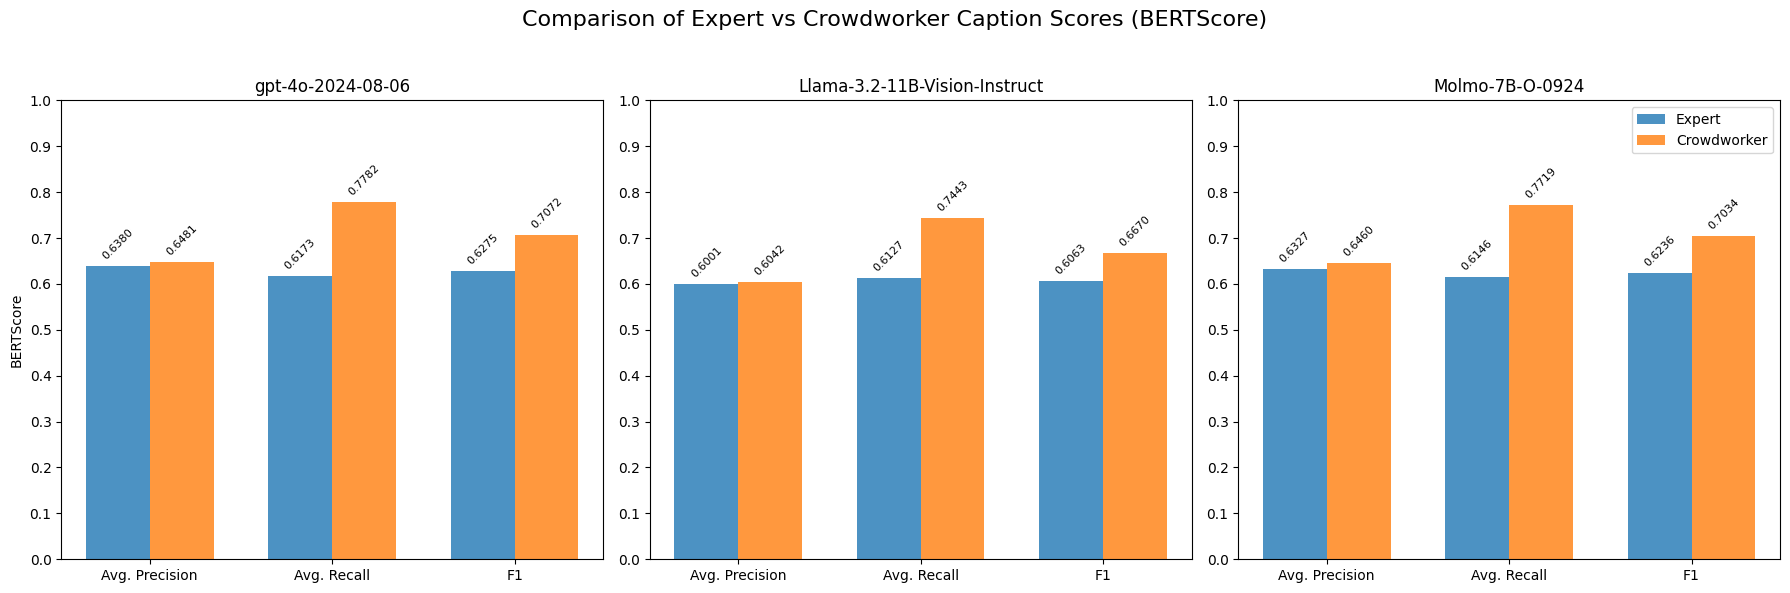

In [64]:
# make a barplot comparing expert vs crowdworker caption scores
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure with 3 subplots (one for each model)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Get model names
model_names = list(expert_caption_scores_average.keys())

# Set width of bars
bar_width = 0.35

# Metrics to plot
metric_labels = ["Avg. Precision", "Avg. Recall", "F1"]
x = np.arange(len(metric_labels))

# Colors for expert and crowdworker bars
expert_color = "#1f77b4"  # Blue
crowdworker_color = "#ff7f0e"  # Orange

# Create a plot for each model
for i, model_name in enumerate(model_names):
    ax = axes[i]

    # Extract metrics for this model
    expert_metrics = [
        expert_caption_scores_average[model_name]["avg_precision"],
        expert_caption_scores_average[model_name]["avg_recall"],
        expert_caption_scores_average[model_name]["f1"],
    ]

    crowdworker_metrics = [
        crowdworker_caption_scores_average[model_name]["avg_precision"],
        crowdworker_caption_scores_average[model_name]["avg_recall"],
        crowdworker_caption_scores_average[model_name]["f1"],
    ]

    # Plot the bars
    expert_bars = ax.bar(
        x - bar_width / 2,
        expert_metrics,
        bar_width,
        label="Expert",
        color=expert_color,
        alpha=0.8,
    )

    crowdworker_bars = ax.bar(
        x + bar_width / 2,
        crowdworker_metrics,
        bar_width,
        label="Crowdworker",
        color=crowdworker_color,
        alpha=0.8,
    )

    # Add text labels
    for j in range(len(metric_labels)):
        ax.text(
            x[j] - bar_width / 2,
            expert_metrics[j] + 0.01,
            f"{expert_metrics[j]:.4f}",
            ha="center",
            va="bottom",
            fontsize=8,
            rotation=45,
        )
        ax.text(
            x[j] + bar_width / 2,
            crowdworker_metrics[j] + 0.01,
            f"{crowdworker_metrics[j]:.4f}",
            ha="center",
            va="bottom",
            fontsize=8,
            rotation=45,
        )

    # Set plot labels and formatting
    ax.set_title(model_name)
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels)
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.1))

    # Only add y-label to the first subplot
    if i == 0:
        ax.set_ylabel("BERTScore")

    # Only add legend to the last subplot
    if i == len(model_names) - 1:
        ax.legend(loc="upper right")

# Add an overall title
fig.suptitle(
    "Comparison of Expert vs Crowdworker Caption Scores (BERTScore)", fontsize=16
)

# Adjust layout and display
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for the suptitle
plt.show()

In [62]:
print(json.dumps(expert_caption_scores_average, indent=4))

{
    "gpt-4o-2024-08-06": {
        "avg_precision": 0.6379871547222138,
        "avg_recall": 0.6172776409983635,
        "avg_f1": 0.6244576263427735,
        "f1": 0.6274615638019527
    },
    "Llama-3.2-11B-Vision-Instruct": {
        "avg_precision": 0.6001170825958252,
        "avg_recall": 0.612673567533493,
        "avg_f1": 0.6034319970011711,
        "f1": 0.6063303240218274
    },
    "Molmo-7B-O-0924": {
        "avg_precision": 0.6327319094538688,
        "avg_recall": 0.6146360912919044,
        "avg_f1": 0.6210255318880081,
        "f1": 0.6235527405382768
    }
}


In [63]:
print(json.dumps(crowdworker_caption_scores_average, indent=4))

{
    "gpt-4o-2024-08-06": {
        "avg_precision": 0.6481130465865135,
        "avg_recall": 0.77824267745018,
        "avg_f1": 0.6981616145372391,
        "f1": 0.707241853018856
    },
    "Llama-3.2-11B-Vision-Instruct": {
        "avg_precision": 0.6042492830753327,
        "avg_recall": 0.7443282961845398,
        "avg_f1": 0.6599118036031723,
        "f1": 0.6670136687116356
    },
    "Molmo-7B-O-0924": {
        "avg_precision": 0.6460013055801391,
        "avg_recall": 0.7719316881895065,
        "avg_f1": 0.6952684825658798,
        "f1": 0.7033743915689076
    }
}
